# Technical test - Protein design

This notebook describes an interface design experiment where we will analyse 3D crystal structures of SAR-COV2 spike protein bound with ACE2 enzyme (pdb - 6m0j) and antibody P5A-3CD, rescpectively. We will analyse the interfaces in these two crystal structures and find out the key amino acid residues at the interfaces that are involved in non-covalent interaction in these two structures. We will then query PDBE (www.pdbe.og) and Uniprot (www.uniprot.org) databases to find out available information about the residues. We will analyse the information available from 3D structures and protein databasesn, and use these information to create a platform where we can perform an interface design experiment. 

This notebook divides in three part. First part of this notebook deals with the analysis of the interfacee, second part shows an in-silico mutagenesis platform and thrid part is an evaluation platform. To run this notebook, we need nglview (for visualisation), pymol (for ini-slico mutagenesis), prodigy (A tool from Bonvon lab to calculate binding affinity) and openmm (Open source tool for molecular dynamics). Two conda environments are needed to run this notebook because of conflict in dependencies between Pymol and Prodigy package.Due to conflict in dependencies between different packages, I have used three different conda environment for the work and tried to keep these three parts separate. 

## Part - 1: Analysis of the 3D crystal structures

For the first part of the work, we can create a condo environment. This part uses NGL viewer as a visualizer that can be installed in a conda environent using this command "conda install conda-forge::nglview". 

We will use information from two experimental crystal structures of SARS-COV2 spike protein in complex with ACE2 receptor and antibody P5A-3C8. In order to do that we will use two protein structures 6m0j and 7chp.

Let's start importing the necessary packages for this notebook. 

In [1]:
import os
import requests
import subprocess
import shlex

import nglview
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


We will first look at protein structure 6m0j, which is complex between SARS-COV2 spike protein and the ACE2. The ACE2 protein is in red and spike protein is shown in blue colour. 

In [2]:
nglview.show_pdbid("6m0j")

NGLWidget()

Next crystal structre is the SARs-COV2 spike protein and P5A-3C8 complex, where the spike protein in red, antibody heavy chain in blue and the light chain is shown in solver grey colours, respectively. 

In [3]:
nglview.show_pdbid("7chp")

NGLWidget()

Next we create an oevrlay of these two structures, where the spike protein is shown in golden. Here we can see that both the ACE2 and the antibody bind the spike protein at the same interface. 

In [4]:
nglview.show_structure_file("6m0j_7chp.pdb")

NGLWidget()

Next we will create a method to find out more information about the interfaces using the [PDBe'e REST API](https://www.ebi.ac.uk/pdbe/api/doc). PDBe provides information about protein protein interfaces by using CCP4 PISA software and provides these information via assembly end point, which returns details of all interfacse for given pdbid and assembly id.


In [5]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
class Pdbesearch:
    """
    Class for querying interface information from PDB for a given PDB entry and assembly id
    """
    
    def __init__(self, pdb_id: str, assembly_id: str) -> None:
        """
        :param pdb_id: String
        :param assembly_id: Integer
        """
        self.search_url = 'https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/'
        self.search_options = '&wt=json&rows=100000'
        self.pdb_id = pdb_id
        self.assembly_id = assembly_id


    def url_response(self, url: str) -> dict:
        """
        Getting JSON response from URL
        :param url: String
        :return: JSON
        """
        r = requests.get(url=url)
        # Status code 200 means 'OK'
        if r.status_code == 200:
            json_result = r.json()
            return json_result
        else:
            print(r.status_code, r.reason)
            return None

    def run_search(self) -> dict:
        """
        Running search and getting JSON response
        """

        full_query = self.search_url + self.pdb_id + "/" + self.assembly_id
        print(full_query)
        response = self.url_response(full_query)
        return response

    def get_interface_info(self, interface_id: int) -> dict:
        """
        Getting interface information from JSON response
        :param interface_id: Integer
        :return: Dictionary
        """
        response = self.run_search()
        info_dict = {
        "number_of_residues_at_interface" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_interface_residues'],
        "number_of_hydrogen_bonds" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_hydrogen_bonds'],
        "number_of_salt_bridges" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_salt_bridges'],
        "number_of_disulfide_bonds" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_disulfide_bonds'],
        "stabilisation_energy" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['stabilization_energy'],
        "Interface_area" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['interface_area'],
        }
        
        return info_dict
    
    def get_residues(self, bond_type: str, atom_site: str, interface_id: int) -> list:
        """
        Getting residues for certian bond type and atom site e.g. hydrogen bonds
        :param bond_type: String
        :param atom_site: String
        :param interface_id: Integer
        
        """
        response = self.run_search()
        uniprot_accesiion_id = set(response[self.pdb_id]['assembly']["interfaces"][interface_id][bond_type][f'{atom_site}_unp_accs'])
        print(f"Uniprot accesiion id of the chain is {uniprot_accesiion_id}")
        residues = response[self.pdb_id]['assembly']["interfaces"][interface_id][bond_type][f'{atom_site}_residues']
        
        residues_nums = response[self.pdb_id]['assembly']["interfaces"][interface_id][bond_type][f'{atom_site}_seq_nums']
        list_of_hydrogen_bonding_residues = [mn + str(n) for mn, n in zip(residues, residues_nums)]
        
        return list_of_hydrogen_bonding_residues
    
    


Next we will use this PDBeSearch class to get information about the interfaces. We can access the assembly by the assembly id and then we will get information for individual interfaces by using interface id. 6m0j has one protein - protein interface but 7chp has two protein-protein interfacse one between spike protein and heavy chain and another between spike protein and light chain of the antibody.

In [6]:
spike_protein_ace2 = Pdbesearch('6m0j', '1')
spike_protein_P5A = Pdbesearch('7chp', '1')

In [7]:
spike_protein_ace2_info = spike_protein_ace2.get_interface_info(0)
spike_protein_P5A_info_chain_HE = spike_protein_P5A.get_interface_info(1)
spike_protein_P5A_info_chain_LE = spike_protein_P5A.get_interface_info(2)


https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/6m0j/1
https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1


In [9]:
df = pd.DataFrame([spike_protein_ace2_info, spike_protein_P5A_info_chain_HE, spike_protein_P5A_info_chain_LE]).T
df.columns = ['d{}'.format(i) for i, col in enumerate(df, 1)]
df = df.rename(columns={'d1': 'rbd_ace2', 'd2': 'rbd_chainH', 'd3': 'rbd_chainL'})



In [10]:
df

,rbd_ace2,rbd_chainH,rbd_chainL
number_of_residues_at_interface,194.00,220.00,216.00
number_of_hydrogen_bonds,13.00,19.00,9.00
number_of_salt_bridges,1.00,2.00,0.00
number_of_disulfide_bonds,0.00,0.00,0.00
stabilisation_energy,-10.66,-8.62,-6.19
Interface_area,843.51,697.18,516.46


We can now check what are the residues in the interfaces are involved in non-covaent ineteraction. We can use the bond_type heywords in our get_residues method and using different bond types we can get list of residues involved in different non -covalent interaction. First we can check what are the reidues involved in hydrogen bonding in spike protein and ACE2 interfaces. 

In [11]:
spike_protein_ace2.get_residues(atom_site="atom_site_2", bond_type="hydrogen_bonds", interface_id=0)


https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/6m0j/1
Uniprot accesiion id of the chain is {'P0DTC2'}


['GLY446',
 'TYR449',
 'ASN487',
 'TYR489',
 'GLY496',
 'THR500',
 'TYR505',
 'TYR449',
 'ASN487',
 'GLN493',
 'ASN501',
 'GLY502',
 'TYR505']

Similarly we can check if there are any disulphide bonds exist between the two protein chains. 

In [12]:
spike_protein_P5A.get_residues(atom_site="atom_site_1", bond_type="disulfide_bonds", interface_id=1)


https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
Uniprot accesiion id of the chain is set()


[]

so there are no disulphide bonds between these two protein chains and we can also confirm that from Figure A of the article mentioning 6m0j, where the authors shown that the all disulphide bonds are inside the spike protein.

Now for our design experiment we will make a list of all the interacting residues that are present in the interface. Like before we need to run two calls for the 7chp structures to get information for both the heavy and light chains. 

In [13]:
all_residues_at_the_interface_ace2 = spike_protein_ace2.get_residues(atom_site="atom_site_2", bond_type="other_bonds", interface_id=0)
set(all_residues_at_the_interface_ace2)

https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/6m0j/1
Uniprot accesiion id of the chain is {'P0DTC2'}


{'ALA475',
 'ASN487',
 'ASN501',
 'GLN493',
 'GLN498',
 'GLY446',
 'GLY496',
 'GLY502',
 'LEU455',
 'LYS417',
 'PHE456',
 'PHE486',
 'THR500',
 'TYR449',
 'TYR453',
 'TYR489',
 'TYR505'}

In [14]:
all_residues_at_the_interface_P5A_chainHE = spike_protein_P5A.get_residues(atom_site="atom_site_1", bond_type="other_bonds", interface_id=1)
set(all_residues_at_the_interface_P5A_chainHE)

https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
Uniprot accesiion id of the chain is {'P0DTC2'}


{'ALA475',
 'ARG457',
 'ASN460',
 'ASN487',
 'ASP420',
 'GLN493',
 'GLY416',
 'GLY476',
 'LEU455',
 'LYS417',
 'LYS458',
 'PHE456',
 'PHE486',
 'SER477',
 'THR415',
 'TYR421',
 'TYR453',
 'TYR473',
 'TYR489'}

In [15]:
all_residues_at_the_interface_P5A_chainLE = spike_protein_P5A.get_residues(atom_site="atom_site_1", bond_type="other_bonds", interface_id=2)
set(all_residues_at_the_interface_P5A_chainLE)

https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
Uniprot accesiion id of the chain is {'P0DTC2'}


{'ARG403',
 'ARG408',
 'ASN501',
 'ASP405',
 'GLN493',
 'GLN498',
 'GLU406',
 'GLY496',
 'GLY502',
 'LYS417',
 'SER494',
 'THR500',
 'TYR449',
 'TYR495',
 'TYR505'}

Now we will make a list of all the residues that are present at the interface of spike protein that binds both the ACE2 enzyme and the antibody.

In [16]:
list_of_all_residues_at_interface = list(set(all_residues_at_the_interface_ace2 + all_residues_at_the_interface_P5A_chainHE + all_residues_at_the_interface_P5A_chainLE))
list_of_all_residues_at_interface

['GLN493',
 'GLY476',
 'TYR495',
 'LYS417',
 'ARG457',
 'THR500',
 'LYS458',
 'SER477',
 'ALA475',
 'TYR473',
 'PHE486',
 'GLN498',
 'GLY502',
 'TYR449',
 'GLY416',
 'GLU406',
 'ASP420',
 'TYR453',
 'GLY446',
 'SER494',
 'GLY496',
 'ARG403',
 'THR415',
 'ASP405',
 'TYR421',
 'ARG408',
 'ASN487',
 'ASN501',
 'TYR489',
 'PHE456',
 'LEU455',
 'ASN460',
 'TYR505']

We will save this list of residues in a dataframe and save it for later use. 

In [17]:
list_of_all_residues_at_interface_df = pd.DataFrame(list_of_all_residues_at_interface, columns=["residues"])

Now we will query the Uniprot database for accession id P0DTC2 (SARS-COV2 spike protein) and obtain the information about experiemental mutation a perticular amino acid residues present in that list. 

In [18]:
import sys

def get_mutations_info_from_uniprot(residue_list_to_query: list) -> dict:
    """
    Getting mutations information from Uniprot
    :param residue_list_to_query: list
    :return: Dictionary of residues with mutations information
    """
    dict_of_residues_with_mutations_info = {}
    for residue in residue_list_to_query:
        requestURL = f"https://www.ebi.ac.uk/proteins/api/mutagenesis/P0DTC2?location={residue[-3:]}"

        r = requests.get(requestURL, headers={ "Accept" : "application/json"})

        if not r.ok:
          r.raise_for_status()
          sys.exit()

        responseBody = r.json()
        if (responseBody["features"]):
           dict_of_residues_with_mutations_info[residue] = responseBody["features"][0]["alternativeSequence"]
    return dict_of_residues_with_mutations_info


In [19]:
dict_of_residues_with_mutations_info = get_mutations_info_from_uniprot(list_of_all_residues_at_interface)
dict_of_residues_with_mutations_info


{'GLN493': 'Y',
 'GLY476': 'NVPFSPDGK',
 'LYS417': 'T',
 'SER477': 'NVPFSPDGK',
 'ALA475': 'V',
 'TYR473': 'NVPFSPDGK',
 'PHE486': 'L',
 'GLN498': 'H',
 'GLY502': 'D',
 'TYR453': 'F',
 'GLY446': 'V',
 'SER494': 'P',
 'ARG403': 'T',
 'ASN501': 'T',
 'PHE456': 'L',
 'LEU455': 'Y',
 'TYR505': 'C'}

We can see some key residues with several mutants in the list above (Ser477, GLY476 etc). Now we will save this information in a csv file since we are working with different conda environments. 

In [20]:
residues_with_mutation_info_df = pd.DataFrame(dict_of_residues_with_mutations_info.items(), columns=["residues", "mutation"])
residues_with_mutation_info_df.head()

,residues,mutation
0,GLN493,Y
1,GLY476,NVPFSPDGK
2,LYS417,T
3,SER477,NVPFSPDGK
4,ALA475,V


In [23]:
def write_csv_file(outdir: str, file_name: str, dataframe: pd.DataFrame) -> None:
    """
    function to write a csv file from dataframe 
    """
    if os.path.exists(outdir):
        full_file_path = os.path.join(outdir, file_name)
        dataframe.to_csv(full_file_path, index=False)
    else:
        os.mkdir(outdir)
        full_file_path = os.path.join(outdir, file_name)
        dataframe.to_csv(full_file_path, index=False)

In [24]:
# write a csv file for all residues 
write_csv_file("data/", "all_residue_info.csv", list_of_all_residues_at_interface_df)


In [25]:
# write a csv file for residues with mutagenesis information
write_csv_file("data/", "residues_with_mutagenesis_info.csv", residues_with_mutation_info_df)

In [14]:



import ipykernel
import os 

from pymol import cmd
import pandas as pd

In [15]:
class RunInsilicoMutation:
    """
    Class for running insilico mutation on a given PDB entry and assembly id
    """
    
    def __init__(self, pdb_file: str, chain_id: str) -> None:
        """
        :param pdb_id: String
        :param assembly_id: Integer
        :param chain_id: String
        :param residue_number: String
        :param mutation: String
        """
        self.pdb_file = pdb_file
        self.chain_id = chain_id

    def _run_pymol_mutation(self, original_residue, amino_acid) -> None:
        """
        Running insilico mutation
        """
        os.makedirs(f"data_{self.pdb_file}", exist_ok=True)
        cmd.wizard("mutagenesis")
        cmd.load(self.pdb_file)
        cmd.get_wizard().set_mode(amino_acid)
        cmd.get_wizard().do_select(f"chain {self.chain_id} and resid {original_residue[-3:]}")
        cmd.get_wizard().apply()
        cmd.save(f"data_{self.pdb_file}/{(original_residue[0:3])}{original_residue[-3:]}_{(amino_acid)}-{self.pdb_file}.pdb")
        cmd.reinitialize()
    
    def run_pymol_mutation_on_files(self, list_of_residues_with_mutations_info: list, list_of_amino_acids: list) -> None:
        """
        Running insilico mutation on a list of residues
        :param dict_of_residues_with_mutations_info: Dictionary of residues with mutations information
        :param list_of_amino_acids: List of amino acids
        
        """
        for residue in list_of_residues_with_mutations_info:
            for amino_acid in list_of_amino_acids:
       
                try:
                    self._run_pymol_mutation(residue, amino_acid)
                except Exception as e:
                    print(e)
                    print(f"Could not mutate {residue} to {amino_acid}")
                    pass
        


In [16]:
list_of_amino_acids = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

In [17]:
residues_info_df = pd.read_csv("data/residues_info_df.csv")
residues_info_df.head()

,residues,mutation
0,GLY446,V
1,GLY502,D
2,LEU455,Y
3,ALA475,V
4,ASN501,T


In [18]:
RunInsilicoMutation("pdb6m0j.ent", "E").run_pymol_mutation_on_files(residues_info_df["residues"].to_list(), list_of_amino_acids)

 PyMOL not running, entering library mode (experimental)
Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 15 rotamers loaded.
 Rotamer 9/15, strain=25.35
Selected!
 Mutagenesis: 11 rotamers loaded.
 Rotamer 9/11, strain=27.49
Selected!
 Mutagenesis: 8 rotamers loaded.
 Rotamer 6/8, strain=28.16
Selected!
 Mutagenesis: 3 rotamers loaded.
 Rotamer 3/3, strain=30.37
Selected!
 Mutagenesis: 11 rotamers loaded.
 Rotamer 7/11, strain=22.58
Selected!
 Mutagenesis: 11 rotamers loaded.
 Rotamer 6/11, strain=24.42
Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 8 rotamers loaded.
 Rotamer 4/8, strain=29.43
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 4/4, strain=38.12
Selected!
 Mutagenesis: 3 rotamers loaded.
 Rotamer 1/3, strain=27.67
Selected!
 Mutagenesis: 16 rotamers loaded.
 Rotamer 12/16, strain=22.17
Selected!
 Mutagenesis: 9 rotamers loaded.
 Rotamer 8/9, strain=22.52
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 3/

In [19]:
RunInsilicoMutation("pdb7chp.ent", "E").run_pymol_mutation_on_files(dict_of_residues_with_mutations_info, list_of_amino_acids)

Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 21 rotamers loaded.
 Rotamer 6/21, strain=26.75
Selected!
 Mutagenesis: 9 rotamers loaded.
 Rotamer 1/9, strain=12.66
Selected!
 Mutagenesis: 7 rotamers loaded.
 Rotamer 7/7, strain=10.53
Selected!
 Mutagenesis: 2 rotamers loaded.
 Rotamer 1/2, strain=18.68
Selected!
 Mutagenesis: 13 rotamers loaded.
 Rotamer 5/13, strain=10.26
Selected!
 Mutagenesis: 15 rotamers loaded.
 Rotamer 10/15, strain=11.32
Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 7 rotamers loaded.
 Rotamer 1/7, strain=12.87
Selected!
 Mutagenesis: 5 rotamers loaded.
 Rotamer 5/5, strain=16.09
Selected!
 Mutagenesis: 3 rotamers loaded.
 Rotamer 1/3, strain=31.40
Selected!
 Mutagenesis: 14 rotamers loaded.
 Rotamer 10/14, strain=7.77
Selected!
 Mutagenesis: 11 rotamers loaded.
 Rotamer 6/11, strain=5.23
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 1/4, strain=21.05
Selected!
 Mutagenesis: 2 rotamers loaded.

In [2]:

import prodigy

In [ ]:
!prodigy 

In [5]:
class CalculateBindingEnergy():
    """
    Class for calculating binding energy for a given PDB entry using Prodigy
    """
    def __init__(self, directory: str) -> None:
        self.directory = directory
    
    def _calculate_binding_energy(self, pdb_file: str) -> str:
        """
        Calculating binding energy
        :param pdb_file: String
        :return: Binding enrgy calculate by Prodigy as String
        """
        full_filepath = f"{self.directory}/{pdb_file}"
        d = subprocess.run(shlex.split(f"prodigy {full_filepath}"), stdout=subprocess.PIPE)
        string = d.stdout.decode("utf-8")
        binding_energy = string.splitlines()[-2].split(":")[1]
        return binding_energy
    
    def calculate_binding_energy_for_all_files(self) -> dict:
        """
        Calculating binding energy for all files in a given directory
        :return: Dictionary of binding energy for each file
        """
        binding_energy_dict = {}
        for pdb_file in os.listdir(self.directory):
            binding_energy_dict[pdb_file] = self._calculate_binding_energy(pdb_file)
        return binding_energy_dict

In [7]:
spike_protein_binding_affinity_dict = CalculateBindingEnergy("data_pdb6m0j.ent").calculate_binding_energy_for_all_files()

In [6]:
P5A_spike_protein_binding_affinity_dict = CalculateBindingEnergy("data_pdb7chp.ent").calculate_binding_energy_for_all_files()

In [33]:
def create_and_clean_dataframe(binding_affinity_dict: dict) -> pd.DataFrame:
    """
    Creating and cleaning dataframe
    :param binding_affinity_dict: Dictionary of binding energy for each file
    :return: Pivoted Dataframe ready to plot heatmap
    """
    df = pd.DataFrame(binding_affinity_dict.items(), columns=['pdb_file', 'binding_affinity'])
    df["pdb_file"] = df["pdb_file"].str.split("-").str[0]

    df[['original_residue', 'mutant']] = df.pdb_file.str.split("_", expand=True)
    df.drop(columns=["pdb_file"], inplace=True)
    df["binding_affinity"] = df["binding_affinity"].astype(float)
    mutant_pivot_table = df.pivot_table(index='mutant', columns='original_residue', values='binding_affinity', aggfunc='first')
    return mutant_pivot_table


In [48]:

spike_protein_ace2_mutant_table = create_and_clean_dataframe(spike_protein_binding_affinity_dict)
spike_protein_P5A_mutant_table = create_and_clean_dataframe(P5A_spike_protein_binding_affinity_dict)

<Axes: xlabel='original_residue', ylabel='mutant'>

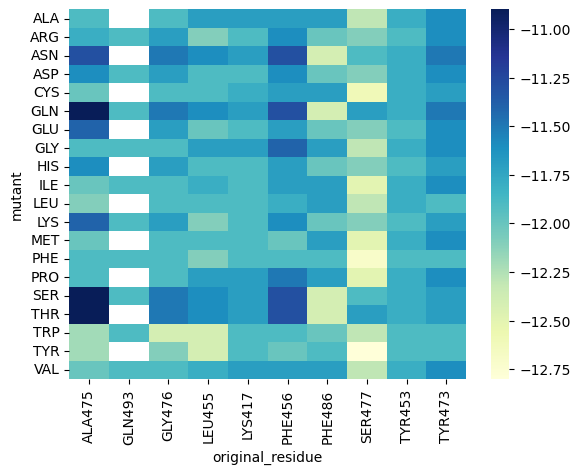

In [53]:
import seaborn as sns
sns.heatmap(spike_protein_ace2_mutant_table, cmap="YlGnBu")

<Axes: xlabel='original_residue', ylabel='mutant'>

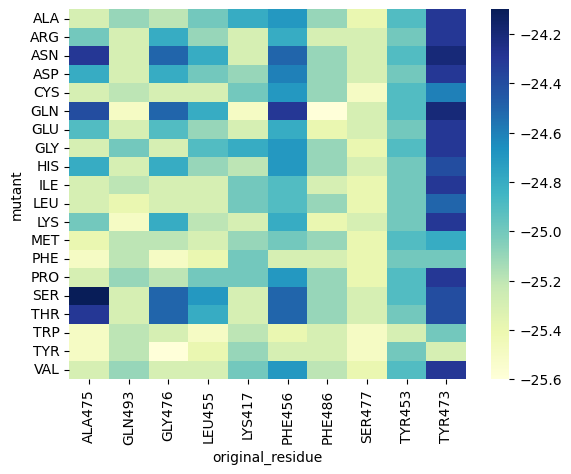

In [54]:
sns.heatmap(spike_protein_P5A_mutant_table, cmap="YlGnBu")

In [19]:
import openmm as mm
import openmm.app as mm_app
from openmm import unit 
from openmm import *
from pdbfixer.pdbfixer import PDBFixer

import numpy as np
import matplotlib.pyplot as plt




ModuleNotFoundError: No module named 'openmm'

In [36]:
mm_app.S

AttributeError: module 'openmm.app' has no attribute 'S'

AttributeError: module 'openmm.unit' has no attribute 'picos'

In [5]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

from pdbfixer.pdbfixer import PDBFixer


In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [9]:
class MDSimulation():
    """
    Class for running simulation using OpenMM
    """
    
    def __init__(self, data_dir: str, pdb_file: str) -> None:
        self.pdb_file_with_full_path = os.path.join(data_dir, pdb_file)
        print(self.pdb_file_with_full_path)
        self.log_file = os.path.join(data_dir, f"{pdb_file}_md_log.txt")
        self.fixed_pdb_file = os.path.join(data_dir, f"{pdb_file}_fixed.pdb")
        self.output_pdb_file = os.path.join(data_dir, f"{pdb_file}_output.pdb")

    
    def pdb_file_fixer(self)-> None:   
     
        fixer = PDBFixer(filename=self.pdb_file_with_full_path)
        print("finding nonstandard residues...")

        fixer.findNonstandardResidues()
        fixer.nonstandardResidues = [(residue, 'ALA') for residue, replacement in fixer.nonstandardResidues]
        fixer.replaceNonstandardResidues()
        print("find missing residues...")
        fixer.findMissingResidues()
        print("find missing atoms...")
        fixer.findMissingAtoms()
        print("replace nonstandard residues...")
        print("add missing atoms...")
        fixer.addMissingAtoms()
        fixer.removeHeterogens(False)
        print("add missing hydrogens...")
        fixer.addMissingHydrogens(7.0)
        maxSize = max(max((pos[i] for pos in fixer.positions))-min((pos[i] for pos in fixer.positions)) for i in range(3))
        boxSize = maxSize*Vec3(1, 1, 1)
        fixer.addSolvent(boxSize)
        PDBFile.writeFile(fixer.topology, fixer.positions, open(self.fixed_pdb_file, 'w'))
        print(f"Written fixed pdb file: {self.fixed_pdb_file}")
    
    def run_md_simulation(self) -> None:
        """
        Running simulation
        """
        pdb = PDBFile(self.fixed_pdb_file)
        forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')


        forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')


        # Combine the molecular topology and the forcefield
        system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
                nonbondedCutoff=1*nanometer, constraints=HBonds)

        # Create the integrator to use for advacing the equations of motion.
        # It specifies a Langevin integrator.
        # The paramters set are temperature, friction coefficient, and timestep.
        integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

        # Combines the molecular topology, system, and integrator
        # to begin a new simulation.
        simulation = Simulation(pdb.topology, system, integrator)
        simulation.context.setPositions(pdb.positions)

        # Perform local energy minimization
        print("Minimizing energy...")
        simulation.minimizeEnergy(maxIterations=100)

        # Write the trajectory to a file called "output.pdb"
        simulation.reporters.append(PDBReporter(self.output_pdb_file, 1000))

        # Report infomation to the screen as the simulation runs
        simulation.reporters.append(StateDataReporter(stdout, 10, step=True,
                potentialEnergy=True, temperature=True))

        #Run the simulation for 1000 timsteps


        # Report infomation to the screen as the simulation runs
        simulation.reporters.append(StateDataReporter(stdout, 100, step=True,
                potentialEnergy=True, temperature=True))

        simulation.reporters.append(StateDataReporter(self.log_file, 100, step=True,
                potentialEnergy=True, temperature=True))

        print("Running simulation...")
        simulation.step(1000)

        print("Done!")        
        
    def plot_energy(self) -> None:
        """
        Plotting energy
        """
        data = np.loadtxt(self.log_file, delimiter=',')
        print(data)

        step = data[:,0]
        potential_energy = data[:,1]
        temperature = data[:,2]

        plt.plot(step, potential_energy)
        plt.xlabel("Step")
        plt.ylabel("Potential energy (kJ/mol)")
        plt.show()
        plt.plot(step, temperature)
        plt.xlabel("Step")
        plt.ylabel("Temperature (K)")
        plt.show()

    

In [10]:
R = MDSimulation("data_pdb7chp.ent", "LYS417_VAL-pdb7chp.ent.pdb")
R.pdb_file_fixer()

data_pdb7chp.ent\LYS417_VAL-pdb7chp.ent.pdb
finding nonstandard residues...
find missing residues...
find missing atoms...
replace nonstandard residues...
add missing atoms...
add missing hydrogens...
Written fixed pdb file: data_pdb7chp.ent\LYS417_VAL-pdb7chp.ent.pdb_fixed.pdb


In [11]:
R.run_md_simulation()

Minimizing energy...
Running simulation...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
10,-1860886.2934706684,97.39572451003397
20,-1888011.073158775,140.78899957678266
30,-1899831.8648800375,164.8885633881669
40,-1897127.2534820572,172.89352200892696
50,-1892132.2827989582,178.6348151765014
60,-1888530.1940292032,185.11783493841105
70,-1886725.2425360656,192.9749980515464
80,-1883549.4180314096,197.67839525963436
90,-1881266.5373061819,202.65336612030598
100,-1878199.923653152,207.75290128784664
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-1878199.923653152,207.75290128784664
110,-1875367.7665226497,212.56814982747787
120,-1873254.2553546093,217.21482194330449
130,-1871510.9056668803,222.09368944172786
140,-1868380.677497038,225.3077170187316
150,-1865489.7030132958,228.546669102332
160,-1862855.949723828,231.73596402170102
170,-1860894.8106856586,235.298931483128
180,-1858942.6659028395,237.8711673034398
190,-1856555.4969646228,240.41758832976177
200,-185414

[[ 1.00000000e+02 -1.87819992e+06  2.07752901e+02]
 [ 2.00000000e+02 -1.85414577e+06  2.42368157e+02]
 [ 3.00000000e+02 -1.83695881e+06  2.64159824e+02]
 [ 4.00000000e+02 -1.82508271e+06  2.75905670e+02]
 [ 5.00000000e+02 -1.81819461e+06  2.85064272e+02]
 [ 6.00000000e+02 -1.81214813e+06  2.89498394e+02]
 [ 7.00000000e+02 -1.80820523e+06  2.91038904e+02]
 [ 8.00000000e+02 -1.80785574e+06  2.94872259e+02]
 [ 9.00000000e+02 -1.80485951e+06  2.96151564e+02]
 [ 1.00000000e+03 -1.80234987e+06  2.96882780e+02]]


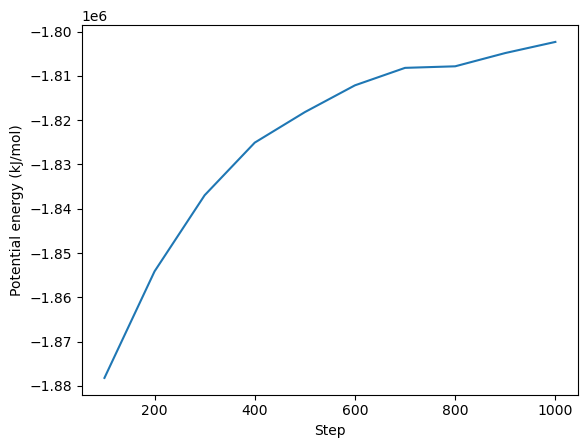

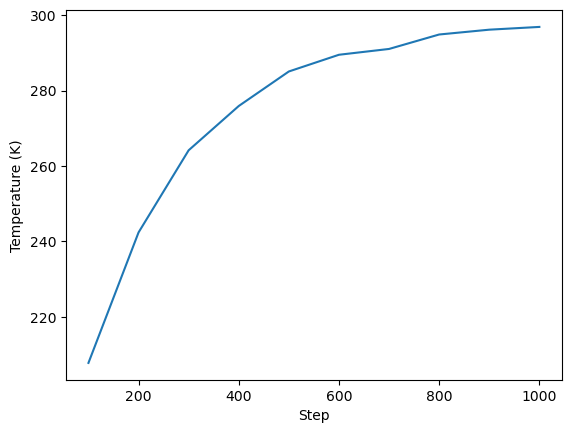

In [12]:
R.plot_energy()